# Measurements & Quantification Notebook

<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../notebooks/07_measurement_and_quantification/measurement_and_quantification_notebook.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/07_measurement_and_quantification/measurement_and_quantification_notebook.ipynb" target="_blank">
        <img class="button-icon" src="../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [ ]:
# /// script
# requires-python = ">=3.10"
# dependencies = [
#     "matplotlib",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "tifffile",
#     "imagecodecs",
#     "pandas",
# ]
# ///

## Overview

In this notebook, we will explore one possible approach to **extracting**, **measuring**, and **quantifying** information from **fluorescence microscopy images**, or, in other words, how to **go from images, to numbers, to plots**.

While fluorescence images can contain a wide range of information, in this notebook, as an example, we will focus on extracting **quantitative information** about the **intensity** of the fluorescence signal and the **morphology** of the objects in the image, mainly using the [**scikit-image**](https://scikit-image.org/docs/stable/) library.

In addition, we will learn how to save the extracted information as a **.csv file** using the [**pandas**](https://pandas.pydata.org/docs/) library.

The images we will use for this section can be downloaded from the <a href="" download> <i class="fas fa-download"></i> Classic Segmentation Dataset</a>. We will also need the **labelled images** that we created in the [Classic Segmentation](../05_segmentation/classic/classic.md) section.

<p class="alert alert-info">
    <strong>Note:</strong> The images from <strong>Classic Segmentation Dataset</strong> have been pre-processed to remove the background and correct for illumination variations (flat-field correction) and are therefore of type <strong>float32</strong>.
</p>

**TODO: UPDATE THE LINK TO THE DATASET AND TO THE CLASSIC SEGMENTATION**
**THE DATASET IS TOO BIG TO BE STORED ON GITHUB**

## Importing libraries

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import tifffile

## Load and Display Images

Let's load and display with `matplotlib` our raw and segmented images (labeled images):

In [ ]:
# raw image and labeled mask
image = tifffile.imread("../../_static/images/quant/DAPI_wf_10.tif")
labeled_mask = tifffile.imread("../../_static/images/quant/DAPI_wf_10_labels.tif")

# Display results
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(122)
plt.imshow(labeled_mask, cmap="nipy_spectral")
plt.title("Labeled Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

## Accessing single objects in the labeled image

Remember that a **labeled image** is an image where each pixel is assigned a **unique value** (or label) that corresponds to a specific object or region in the image, in our case, nuclei. This means that each nucleus in the image is represented by a unique integer value, and all pixels that belong to the same nucleus share the same value.

For example, let's try to create a new image that contains only the pixels of the first nucleus in the labeled image:

In [ ]:
# create an image that contains only the pixels of the first nucleus in the labeled image
nucleus_1 = labeled_mask == 1

# Plot the extracted nucleus image
plt.figure(figsize=(6, 6))
plt.imshow(nucleus_1, cmap="gray")
plt.title("Nucleus 1")
plt.axis("off")
plt.show()

This new image we obtained is a **boolean binary mask** with value `False` for background and `True` for the nucleus number 1.

To verify that this is indeed a binary mask, we can query for the minimum and maximum value using the `np.min()` and `np.max()` functions:


In [ ]:
print(np.min(nucleus_1))
print(np.max(nucleus_1))

## Manual Extraction of Properties

Now we can for example use this mask to extract and print the intensity values of the pixels that belong to this nucleus from the original image.

In [ ]:
# Extract the intensity values of the pixels that belong to this nucleus from the original image
nucleus_1_intensity = image[nucleus_1]
# Print the intensity values
print(nucleus_1_intensity)

We can now calculate and print for example the **mean intensity** using the `np.mean()` function:

In [ ]:
nucleus_1_mean_intensity = np.mean(nucleus_1_intensity)
print(f"Mean intensity of nucleus 1: {nucleus_1_mean_intensity}")

Or we can measure and print the area in pixels of the nucleus 1, which simply corresponds to the total number of pixels that have the value `True` in the binary mask. We can do this by using the `np.sum()` function:

In [ ]:
nucleus_1_area = np.sum(nucleus_1)
print(f"Area of nucleus 1: {nucleus_1_area}")

To convert the area to a more meaningful unit, such as micrometers squared, we need to know the pixel size of the image.

If we assume a pixel size of 0.325 micrometers, we can convert the area from pixels to square micrometers by multiplying by the square of the pixel size:

In [ ]:
pixel_size = 0.325  # µm
nucleus_1_area_um2 = nucleus_1_area * (pixel_size**2)
print(f"Area of nucleus 1: {nucleus_1_area_um2} um^2")

## Automated Extraction of Properties

We could definitely implement a function that would automate the extraction of intensity values or the area for all nuclei in the labeled image, as well as implement more complex measurements but luckily, we don't have to do it ourselves, as there are libraries that can help us with this task and more in a very efficient way.

The [`skimage.measure`](https://scikit-image.org/docs/stable/api/skimage.measure.html) module from the **scikit-image** package provides several tools to measure properties of image regions. It is especially powerful when working with **labeled segmentation masks**, where each object in an image is assigned a unique integer label.

This module is a foundational tool for extracting morphological and intensity-based features from binary or labeled images.

A useful function in `skimage.measure` is [`regionprops`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops):

**Parameters:**
- `label_image` — A 2D or 3D array where **each unique non-zero integer** corresponds to a labeled object (typically from `skimage.measure.label`).
- `intensity_image` *(optional)* — The raw grayscale image associated with the label mask, used to compute intensity features like mean or standard deviation.

For example:

```python
skimage.measure.regionprops(label_image, image)
```

**Returns:**
- A `list` of `RegionProperties` objects — one for each labeled object. **Each object contains attributes describing shape, position, and optionally intensity** and can be accessed with dot notation (e.g., `RegionProperties.area` or `RegionProperties.mean_intensity`).

In the table below, we summarize some of the common features that can be extracted using this function:

| Measurement | Description |
|-------------|-------------|
| area | Measures the number of pixels in the object (size) |
| perimeter | Approximates the length around the object |
| eccentricity | Quantifies elongation—how stretched the shape is |
| solidity | Indicates shape irregularity by comparing area to convex area |
| extent | Compares object area to its bounding box area |
| orientation | Measures the angle of the major axis of the object |
| mean_intensity | Averages pixel values inside the region (if intensity image is given) |
| max_intensity | Finds the brightest pixel value inside the object |
| intensity_image | Extracts the raw intensity image cropped to the object |
| centroid | Finds the object's center of mass (position in the image) |
| bbox | Gives the bounding box coordinates of the object |

Let's create a variable named `props` to store the result of the `skimage.measure.regionprops` function using the `labeled_mask` and the original `image` as inputs:

In [72]:
props = skimage.measure.regionprops(labeled_mask, image)

Since the `props` variable is a `list` of `RegionProperties`, we can access the properties of each object using indexing. For example, to access the properties of the first object (or the first nucleus), we can use `props[0]`.

In [ ]:
props[0]

From the [`regionprops`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops) documentation (and as mentioned above), we can see that we can access a lot of properties for each `RegionProperties` in the list. For example, to get the **mean intensity** of the first region (nucleus), we can use `props[0].mean_intensity`:

In [ ]:
props[0].mean_intensity

As you can see, is the same value we obtained manually before.

<p class="alert alert-info">
    <strong>Note:</strong> To see all the available properties for <em>RegionProperties</em> use the <em>dir()</em> function which will list all the attributes and methods of the object: <em>dir(props[0])</em>. Ignore all the methods that start with <em>__</em> (double underscore) as they are special methods in Python.
</p>

Let's now extract the **mean intensity** of all nuclei and plot it using `matplotlib` in an histogram:

In [ ]:
# Extract mean intensity of all regions
mean_intensities = []
for prop in props:
    mean_intensities.append(prop.mean_intensity)
# NOTE: this for loop can also be written as a list comprehension:
# mean_intensities = [prop.mean_intensity for prop in props]

# plot the mean intensities in a histogram
plt.figure(figsize=(8, 4))
plt.hist(mean_intensities, bins=50, color="blue", alpha=0.7)
plt.title("Mean Intensities of Nuclei")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.show()

If you remember from the [Classic Segmentation](../05_segmentation/classic/classic.md) section, the dataset we are using contains images of **HeLa cells** stained with **DAPI**, a fluorescent dye that binds to DNA.

We know that:
- In normal condition, mammalian cells in the **G1** phase of the cell cycle are **diploid** and thus have two sets of chromosomes (**2n**).
- Cells in the **G2** phase and are **tetraploid** (**4n**).
- During **S** phase (DNA doubling), cells have a DNA content ranging between **2n** and **4n**.

Therefore, by looking at the DNA content (2n vs 4n) in a cell nucleus, it should be possible to discriminate between the cell cycle phases.

Since DAPI labels the DNA depending on the DNA content, by **measuring** the **total DAPI nuclear intensity (integrated density)**, we might be able to **plot the cell cycle phase** distribution of the entire population of cells.

The total intensity, also known as **integrated density**, is defined as the **sum of the pixel intensities within a region of interest**, which in our case is the nucleus. To calculate it we can use the `image_intensity` attribute of the `RegionProperties` object, which contains the values of all the pixels in the region of interest (the nucleus) and sum them up using the `np.sum()` function.

For example:

**TODO: FIX LINK TO CLASSIC SEGMENTATION**

In [56]:
np.sum(props[0].image_intensity)

np.float32(236.06673)

### ✍️ Exercise: Plot DAPI Nuclear Integrated Density Distribution from the Entire Dataset

In this exercise, let's try to:
- create a `dataset_integrated_density_list` list variable
- write a `for loop` that will iterate over (load) all pairs of images (raw and labeled) in the dataset
    - extract the total integrated density of each nucleus in each image
    - store the results in a list named `dataset_integrated_density_list`
- plot the distribution of the integrated density values using `matplotlib` and a histogram (bin size of 250)

In [ ]:
raw_image_path = Path("/Users/fdrgsp/Desktop/in")
labels_image_path = Path("/Users/fdrgsp/Desktop/out")

# Create a list to store the integrated density values for all nuclei in the dataset
integrated_density_list = []

for raw_image_file in raw_image_path.glob("*.tif"):
    # Load the raw image
    raw_image = tifffile.imread(raw_image_file)
    # Get image name without extension
    image_name = raw_image_file.stem
    # Load the corresponding labeled image
    labels_image_file = labels_image_path / f"{image_name}_labels.tif"
    if not labels_image_file.exists():
        print(f"Labels file for {image_name} not found. Skipping...")
        continue
    labeled_mask = tifffile.imread(labels_image_file)
    # Get region properties
    props = skimage.measure.regionprops(labeled_mask, intensity_image=raw_image)
    # Calculate total integrated density for each nucleus
    for prop in props:
        integrated_density = np.sum(prop.image_intensity)
        integrated_density_list.append(integrated_density)
    # same as:
    # integrated_density_list.extend([np.sum(prop.image_intensity) for prop in props])

# Plot the distribution of integrated density values
plt.figure(figsize=(8, 4))
plt.hist(integrated_density_list, bins=250, color="blue", alpha=0.7)
plt.title("Integrated Density Distribution of Nuclei")
plt.xlabel("Integrated Density")
plt.ylabel("Frequency")
plt.show()

<!-- <div align="left"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/ilastik/sem_to_inst.png" alt="Ilastik Logo" width="700"></div> -->
<div align="left"> <img src="../../_static/images/quant/integrated_density_distribution.png" alt="cell_hist" width="700"></div>

## From Properties to Tables

There is another useful function in the `skimage.measure` module called [`regionprops_table`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table) that allows us to create a table of properties for each region in the labeled image.

Looking at the [documentation](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table), we can see that this function, instead of a `list`, returns a `dict` object (dictionary type as we've seen in [Data Structures: Dictionaries](../03_python_basics/python_basics_notebook.ipynb)) where each property is a `key` and the `values` are arrays containing the property values for each region in the labeled image.

The main attribute of this function are:
- **label_image**: The labeled image where each unique integer corresponds to a labeled object.
- **intensity_image** *(optional)*: The raw grayscale image associated with the label mask (used to compute intensity features).
- **properties** *(optional)*: A list of properties to include in the table. If not specified, all properties will be included.

For example:

```python
props_dict = regionprops_table(label_image, raw_image, properties=['area', 'perimeter'])
```

Let's see how we can use this in practice and create a DataFrame with the `image_intensity` and `area` properties for each nucleus in the labeled image.

First we need to reload one raw image and the corresponding labeled image:x

In [87]:
# raw image and labeled mask
image = tifffile.imread("../../_static/images/quant/DAPI_wf_10.tif")
labeled_mask = tifffile.imread("../../_static/images/quant/DAPI_wf_10_labels.tif")

Create the dictionary with the `regionprops_table` function and print the results:

In [88]:
props_df = skimage.measure.regionprops_table(
    labeled_mask, intensity_image=image, properties=["image_intensity", "area"]
)
print(props_df)

{'image_intensity': array([array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              ...,
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(38, 45), dtype=float32),
       array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0., -0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              ...,
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(51, 52), dtype=float32),
       array([[ 0.,  0.,  0., ...,  0.,  0., -0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              ...,
              [ 0.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  

Since `props_dict` is a dictionary, we can access the properties of each region using the keys of the dictionary. Each key corresponds to a property, and the associated value is an array containing the property values for each region.

For example, to access the area of each region, we can do:

```python
areas = props_dict['area']
```

Similarly, we can access and print `image_intensity` property:

In [89]:
integrated_density_list = props_df["image_intensity"]
print(integrated_density_list)

[array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(38, 45), dtype=float32)
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., -0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(51, 52), dtype=float32)
 array([[ 0.,  0.,  0., ...,  0.,  0., -0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., -0.,  0.]], shape=(50, 46), dtype=float32)
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 

There is not yet an evident advantage of using `regionprops_table` over `regionprops` at this point, but this method becomes useful when we want to create a table with all the properties of each region in the labeled image as well as save it as a `.csv` file. In fact, this `props_df` output can be used to directly create a [`**pandas**`](https://pandas.pydata.org/docs/) DataFrame.

[`**pandas**`](https://pandas.pydata.org/docs/) is a python library that provides...

**------------------------TO BE CONTINUED----------------------------------**

Let's now create a DataFrame with the `props_df` variable and print it:

In [90]:
props_df = pd.DataFrame(props_df)
print(props_df)

                                       image_intensity    area
0    [[-0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0....  1312.0
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1748.0
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1729.0
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1351.0
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1185.0
..                                                 ...     ...
110  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1622.0
111  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  3556.0
112  [[0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  1971.0
113  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1488.0
114  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1339.0

[115 rows x 2 columns]


We can notice that now we converted the `dict` file in a more tabular format, which is easier to work with for data analysis and manipulation tasks. The rows of the DataFrame correspond to the regions (nuclei) in the labeled image, and the columns correspond to the properties of each region.

For example we can now access the `image_intensity` property by the column name as key:

In [98]:
image_intensity = props_df["image_intensity"]
print(image_intensity)

0      [[-0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0....
1      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                             ...                        
110    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
111    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
112    [[0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
113    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
114    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: image_intensity, Length: 115, dtype: object


And if we want to get the integrated density values for the fist nucleus, we can do (similarly as before):

In [92]:
integrated_density_0 = np.sum(image_intensity[0])
print(integrated_density_0)

333.60358


And, similarly to before, to get the integrated density values for all nuclei, we can use create a list where we sum the pixel intensities for each nucleus:

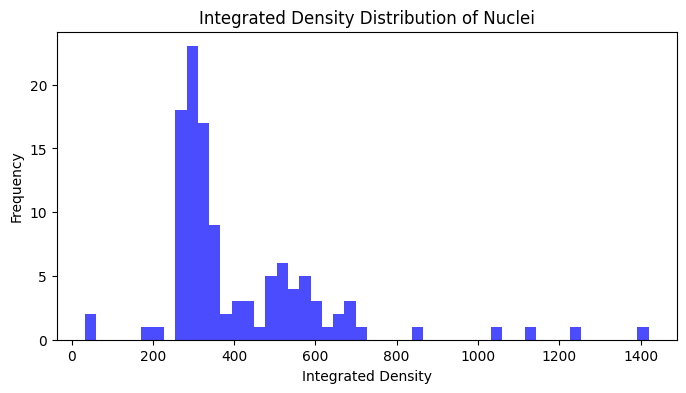

In [100]:
# Calculate integrated density for each nucleus
integrated_densities = []
for intensity_array in props_df["image_intensity"]:
    integrated_density = np.sum(intensity_array)
    integrated_densities.append(integrated_density)
# same as:
# integrated_densities = [np.sum(intensity_array) for intensity_array in props_df['image_intensity']]

# Plot histogram of integrated densities
plt.figure(figsize=(8, 4))
plt.hist(integrated_densities, bins=50, color="blue", alpha=0.7)
plt.title("Integrated Density Distribution of Nuclei")
plt.xlabel("Integrated Density")
plt.ylabel("Frequency")
plt.show()

**TODO: ADD SOME NICE PANDAS FEATURE????**